In [2]:
using ProgressMeter
using MLDataPattern
import Nets
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
include("pympc.jl")

Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [20]:
l = 1.
g = 10.
N = 10
ω = √(g/l)

A = [
    0. 0 1 0
    0  0 0 1
    ω^2  0 0 0
    0  ω^2 0 0
    ]
B = [
    0. 0
    0 0
    -ω^2 0
    0 -ω^2
    ]
Δt = 0.1
pysys = PyMPC.dynamical_systems.DTLinearSystem[:from_continuous](A, B, Δt)

x_max = 10 * [0.1, 0.1, 0.1, 0.1]
x_min = -x_max
u_max = 10 * [0.1, 0.1]
u_min = -u_max

Q = 100 * eye(4)
R = eye(2)

X_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(10*x_min, 4, 1), reshape(10*x_max, 4, 1))[:assemble]()
U_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(u_min, 2, 1), reshape(u_max, 2, 1))[:assemble]()
controller = PyMPC.control.MPCController(pysys, N, "two", Q, R, X=X_bounds, U=U_bounds)

PyObject <pympc.control.MPCController instance at 0x13fe8bcb0>

In [21]:
# explicit_controller = @time control.MPCExplicitController(controller[:condensed_program])

In [22]:
qp = controller[:condensed_program]

num_samples = 1000
data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

@showprogress for i in 1:num_samples
    while true
        x = x_min + rand(length(x_min)) .* (x_max - x_min)
        status, u, J = PyMPC.solve_qp(qp, x)
        if status == :Optimal
            push!(data, (x, hcat(u[1:length(u_min), :], J[1:length(u_min), :])))
            break
        end
    end
end

train_data, test_data = splitobs(data, 0.5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [23]:
widths = [4, 8, 8, 8, 2]
net = Nets.Net(widths)

# sgdopts = Nets.SGDOpts(
#     learning_rate=0.1,
#     batch_size=25)
nepoch = 100

loss = (params, x, y) -> sum(abs2, y - Nets.predict_sensitivity(net, params, x))
loss_no_sensitivity = (params, x, y) -> sum(abs2, y[:, 1] - Nets.predict(net, params, x))

(::#21) (generic function with 1 method)

In [24]:
params = 2 * (rand(net) .- 0.5)
losses = Float64[]

@showprogress for i in 1:nepoch
    Nets.adam!(loss, params, train_data, Nets.AdamOpts(learning_rate=0.1 * 0.95^i, batch_size=25))
    push!(losses, mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), test_data))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02



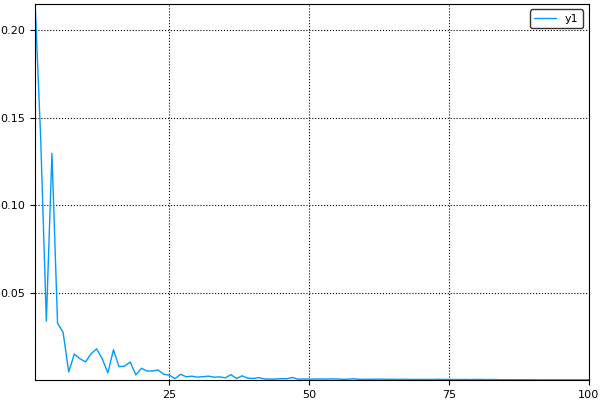

In [25]:
plot(losses)


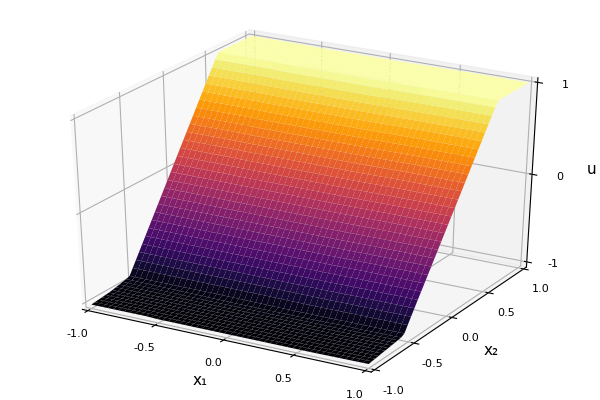

In [26]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> Nets.predict(net, params, [x, y, 0, 0])[2], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt


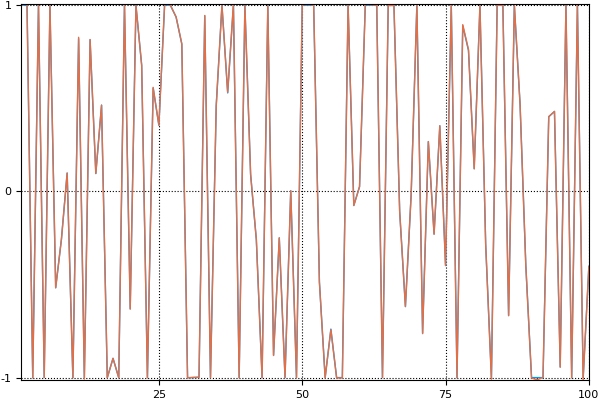

In [27]:
plt = plot([u[1] for (x, u) in test_data[1:100]], legend=nothing)
plot!(plt, [Nets.predict(net, params, x)[1] for (x, u) in test_data[1:100]])
plt


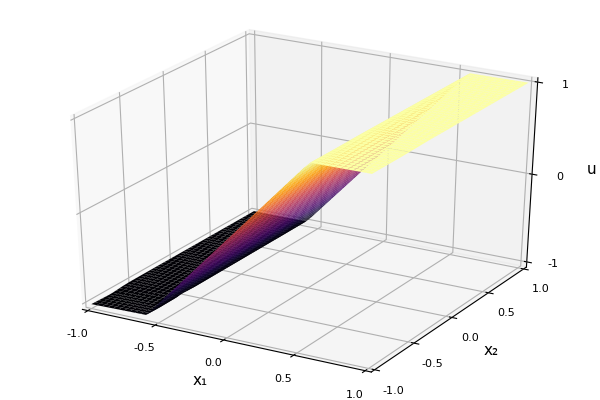

In [28]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> Nets.predict(net, params, [x, y, 0, 0])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt

In [29]:
using DrakeVisualizer, GeometryTypes, CoordinateTransformations

In [51]:
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

Process(`/Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/DrakeVisualizer/src/../deps/usr/bin/drake-visualizer`, ProcessRunning)

In [52]:
vis = Visualizer()[:pendulum]
delete!(vis)
setgeometry!(vis[:com], HyperSphere(Point(0., 0, 0), 0.1))
setgeometry!(vis[:foot], HyperSphere(Point(0., 0, 0), 0.02))

Visualizer with path prefix Symbol[:pendulum, :foot] using LCM LCMCore.LCM(Ptr{Void} @0x00007ffd8b6eadd0, "", RawFD(72), LCMCore.Subscription[LCMCore.Subscription{LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#9{DrakeVisualizer.CoreVisualizer}}}(LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#9{DrakeVisualizer.CoreVisualizer}}(DrakeVisualizer.Comms.CommsT, DrakeVisualizer.handle_msg), Ptr{Void} @0x00007ffd8c878040)])

In [53]:
errs = []

function simulate(x0, ts::StepRangeLen=0:0.01:5)
    x = copy(x0)
    for t in ts
        u = Nets.predict(net, params, x)
        u = clamp.(u, u_min, u_max)
#         status, u_mpc, J = PyMPC.solve_qp(qp, x)
#         push!(errs, norm(u - u_mpc[1:2]))
        
        ẋ = A * x + B * u
        x .+= step(ts) .* ẋ
        settransform!(vis[:com], Translation(x[1], x[2], 1))
        settransform!(vis[:foot], Translation(u[1], u[2], 0))
        sleep(step(ts))
    end
end

simulate (generic function with 2 methods)

In [59]:
empty!(errs)
x = x_min + rand(length(x_min)) .* (x_max - x_min)

status, u_mpc, J = PyMPC.solve_qp(qp, x)
@show status
simulate(x, 0:0.01:3)

status = :Optimal


In [21]:
function simulate_mpc(x0, ts::StepRangeLen=0:0.01:5)
    x = copy(x0)
    for t in ts
        status, u, J = PyMPC.solve_qp(qp, x)
        u = clamp.(u[1:2], u_min, u_max)
        ẋ = A * x + B * u
        x .+= step(ts) .* ẋ
        settransform!(vis[:com], Translation(x[1], x[2], 1))
        settransform!(vis[:foot], Translation(u[1], u[2], 0))
        sleep(step(ts))
    end
end

simulate_mpc (generic function with 2 methods)

In [23]:
x = x_min + rand(length(x_min)) .* (x_max - x_min)
simulate_mpc(x)